In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("data/Chest_xray_Corona_Metadata.csv")
data

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,Normal
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,Normal
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,Normal
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,Normal
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,Normal
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [2]:
from typing import Optional, Sequence

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import torchvision
from PIL import ImageFile
import matplotlib.pyplot as plt
import cv2
from torch.optim.lr_scheduler import StepLR
import random
import copy
from torch.utils.data import random_split
import torchvision
from torch.autograd import Variable
import torch.utils.data
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch import Tensor


# Setting path

In [3]:
import sys
print(sys.version)
data_dir = os.getcwd()
# data_dir = '/home/ilkay/Documents/mahyar/ChestXrays'
train_dir = data_dir + '/train1' #contains training images
test_dir = data_dir + '/test1'
val_dir = data_dir + '/val1'

print(train_dir)

3.7.7 (default, May  7 2020, 21:25:33) 
[GCC 7.3.0]
/home/ilkay/Documents/mahyar/ChestXrays/train1


# Data loader

In [4]:
image_size = 224
train_transforms = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.RandomVerticalFlip(p=0.5),
            torchvision.transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

test_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
train_dataset = ImageFolder(train_dir, train_transforms)
test_dataset = ImageFolder(test_dir, test_transforms)
val_dataset = ImageFolder(val_dir, val_transforms)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

In [5]:
batch_size = 8 

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

# Loading the model

In [6]:
import torchvision.models as models
n_classes = 4

resnet = models.resnet50(pretrained=False).cuda()
model = resnet
model.classifier = nn.Linear(1024, n_classes)

print(model)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# MultiClass Focal Loss implementation

In [7]:

class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return 0.
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 0.,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:
    """Factory function for FocalLoss.
    Args:
        alpha (Sequence, optional): Weights for each class. Will be converted
            to a Tensor if not None. Defaults to None.
        gamma (float, optional): A constant, as described in the paper.
            Defaults to 0.
        reduction (str, optional): 'mean', 'sum' or 'none'.
            Defaults to 'mean'.
        ignore_index (int, optional): class label to ignore.
            Defaults to -100.
        device (str, optional): Device to move alpha to. Defaults to 'cpu'.
        dtype (torch.dtype, optional): dtype to cast alpha to.
            Defaults to torch.float32.
    Returns:
        A FocalLoss object
    """
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

# Multi calss accuracy implementation

In [8]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

# Hyperparameter setup

In [9]:
###  Here are some training parameters which you can tweak
# Device configuration
#device = torch.device('cuda:0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-3
regularization_rate = 0
# n_epochs = 1
use_gpu = True
###

FL = FocalLoss(gamma = 2)
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# FL = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# fl = FocalLoss()
# criteria = fl()

In [10]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

# Training

In [11]:

from tqdm.notebook import tqdm
n_epochs = 30
learning_rate = 1e-3

total_step = len(train_loader)

print("Begin training.")
for e in tqdm(range(1, n_epochs+1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    if use_gpu:
        model.cuda()
        FL.cuda()

#     for epoch in range(n_epochs):
    train_epoch_loss = 0
    train_epoch_acc = 0
    scheduler.step()
    print('Epoch:', e,'LR:', scheduler.get_lr())
    for ix, data in enumerate(train_loader):
        model.zero_grad()
        img, label = data
        images = img.to(device)
        labels = label.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        train_loss = FL(outputs, labels)
        train_acc = multi_acc(outputs, labels)
       
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        # To monitor the training process we print or log some useful values 
#         if (ix+1) % 10 == 0:
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train_acc:{:.4f}' 
#                    .format(epoch+1, n_epochs, ix+1, train_loss.item()), train_acc)
#   
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()
        for iy, data_ in enumerate(val_loader):
            img_, label_ = data_
            images_ = img_.to(device)
            labels_ = label_.to(device)

            outputs_ = model(images_)
            val_loss = FL(outputs_, labels_)

#             _, predicted = torch.max(outputs_.data, dim = 1)
            val_acc = multi_acc(outputs_, labels_)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
print("End training") 

Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 LR: [0.001]


/home/ilkay/miniconda3/envs/covid/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/ilkay/miniconda3/envs/covid/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 001: | Train Loss: 0.48352 | Val Loss: 0.79400 | Train Acc: 52.960| Val Acc: 42.500
Epoch: 2 LR: [0.001]
Epoch 002: | Train Loss: 0.34345 | Val Loss: 0.35689 | Train Acc: 68.160| Val Acc: 78.750
Epoch: 3 LR: [0.001]
Epoch 003: | Train Loss: 0.33522 | Val Loss: 0.57332 | Train Acc: 66.720| Val Acc: 41.250
Epoch: 4 LR: [0.001]
Epoch 004: | Train Loss: 0.29782 | Val Loss: 0.34694 | Train Acc: 74.720| Val Acc: 71.250
Epoch: 5 LR: [0.001]
Epoch 005: | Train Loss: 0.29696 | Val Loss: 0.51360 | Train Acc: 71.840| Val Acc: 48.750
Epoch: 6 LR: [0.001]
Epoch 006: | Train Loss: 0.29096 | Val Loss: 0.36277 | Train Acc: 74.560| Val Acc: 63.750
Epoch: 7 LR: [0.001]
Epoch 007: | Train Loss: 0.26554 | Val Loss: 0.57431 | Train Acc: 79.840| Val Acc: 61.250
Epoch: 8 LR: [0.001]
Epoch 008: | Train Loss: 0.25655 | Val Loss: 0.41312 | Train Acc: 78.720| Val Acc: 68.750
Epoch: 9 LR: [0.001]
Epoch 009: | Train Loss: 0.24878 | Val Loss: 0.38444 | Train Acc: 84.480| Val Acc: 81.250
Epoch: 10 LR: [0.00025

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

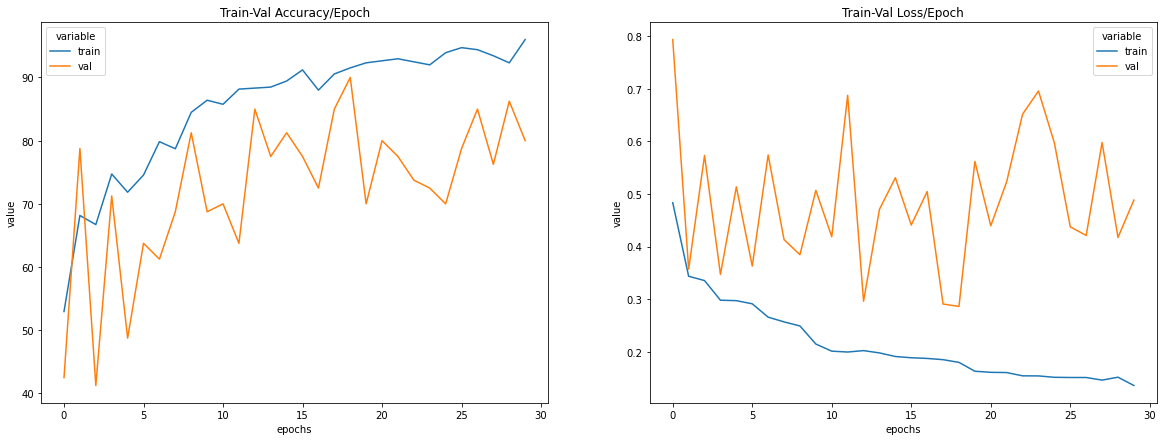

In [12]:
import seaborn as sns

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [13]:
y_pred_list = []
test_epoch_loss = 0
test_epoch_acc = 0
with torch.no_grad():
    model.eval()
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        y_test_pred = model(X_batch)
        test_loss = FL(y_test_pred, Y_batch)

        test_acc = multi_acc(y_test_pred, Y_batch)
        test_epoch_loss += test_loss.item()
        test_epoch_acc += test_acc.item()
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
print('average_acc_train: ',np.array(accuracy_stats['train'])[:20].sum()/20)
# accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
print('average_acc_val: ',np.array(accuracy_stats['val'])[:20].sum()/20)


average_acc_train:  81.608
average_acc_val:  69.9375


In [16]:
print(test_epoch_acc/len(test_loader))

71.11111111111111
